In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
TRAIN_DIR = r"D:\mlmed2026\prac2\training_set"
CSV_PATH = r"D:\mlmed2026\prac2\training_set_pixel_size_and_HC.csv"

In [3]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )


In [4]:
from tensorflow.keras.models import load_model

seg_model = load_model(
    "unet_hc_segmentation.h5",
    custom_objects={"dice_coef": dice_coef}
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


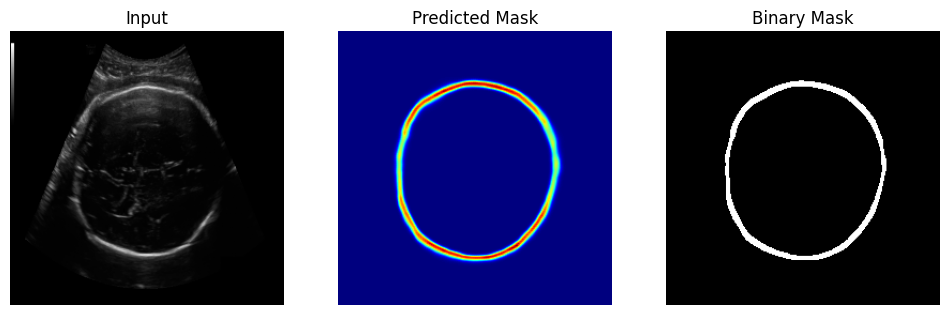

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 256
IMG_PATH = r"D:\mlmed2026\prac2\test_set\000_HC.png"

img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img / 255.0

img_input = np.expand_dims(img, axis=(0, -1))

pred = seg_model.predict(img_input)[0, :, :, 0]
mask = (pred > 0.1).astype(np.uint8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Input"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pred, cmap='jet'); plt.title("Predicted Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(mask, cmap='gray'); plt.title("Binary Mask"); plt.axis("off")
plt.savefig('predict_anno.png')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


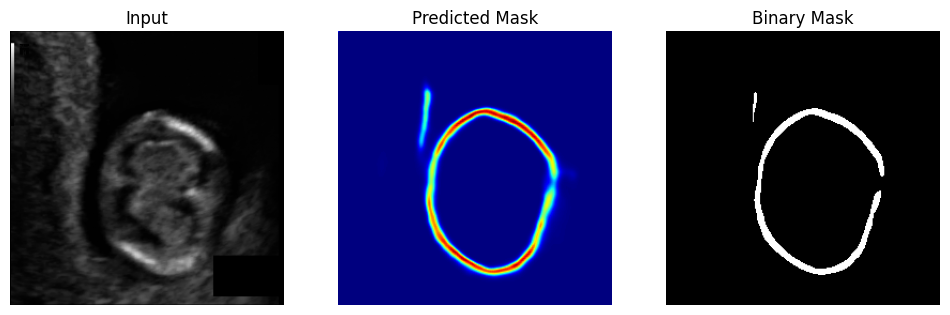

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 256
IMG_PATH = r"D:\mlmed2026\prac2\test_set\001_HC.png"

img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img / 255.0

img_input = np.expand_dims(img, axis=(0, -1))

pred = seg_model.predict(img_input)[0, :, :, 0]
mask = (pred > 0.1).astype(np.uint8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Input"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pred, cmap='jet'); plt.title("Predicted Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(mask, cmap='gray'); plt.title("Binary Mask"); plt.axis("off")
plt.show()


In [30]:

MODEL_PATH = r"D:\mlmed2026\prac2\seg_model.h5"

IMG_SIZE = 256
THRESHOLD = 0.1


In [10]:
import math
def calculate_ellipse_perimeter(path,pixel_size):
    ann =cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(ann, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    (cx,cy),(MA,ma),angle = ellipse
    a = MA / 2
    b = ma / 2
    C_pixels = math.pi * (3*(a+b) - math.sqrt((3*a + b)*(a + 3*b)))
    C_mm = C_pixels * pixel_size
    return C_mm



In [34]:
path = r"D:\mlmed2026\prac2\training_set\000_HC_Annotation.png"
pixel_size = 0.0691358041432

hc_val = calculate_ellipse_perimeter(path,pixel_size)

In [35]:
print(hc_val)

44.67460851409544


In [36]:
TEST_DIR = r"D:\mlmed2026\prac2\test_set"
SAVE_DIR = r"D:\mlmed2026\prac2\predicted_annotations"

MODEL_PATH = r"D:\mlmed2026\prac2\seg_model.h5"

IMG_SIZE = 256
THRESHOLD = 0.1


In [37]:
os.makedirs(SAVE_DIR, exist_ok=True)


In [40]:
from tensorflow.keras.models import load_model

model = load_model(
    "unet_hc_segmentation.h5",
    custom_objects={"dice_coef": dice_coef}
)


In [6]:


SAVE_CSV = r"D:\mlmed2026\prac2\training_set_with_cv2_prediction.csv"


In [7]:
df = pd.read_csv(CSV_PATH)
print(df.head())


     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81


In [11]:
predictions = []

for _, row in df.iterrows():
    filename = row["filename"]
    pixel_size = row["pixel size(mm)"]
    hc_gt = row["head circumference (mm)"]

    ann_name = filename.replace(".png", "_Annotation.png")
    ann_path = os.path.join(TRAIN_DIR, ann_name)

    hc_pred = calculate_ellipse_perimeter(ann_path, pixel_size)

    predictions.append(hc_pred)


In [12]:
df["HC_pred_cv2_mm"] = predictions
df["abs_error_mm"] = abs(df["HC_pred_cv2_mm"] - df["head circumference (mm)"])
df["error_mm"] = df["HC_pred_cv2_mm"] - df["head circumference (mm)"]


In [13]:
mae = df["abs_error_mm"].mean()
rmse = np.sqrt((df["error_mm"]**2).mean())

print(f"CV2 Ellipse MAE  : {mae:.2f} mm")
print(f"CV2 Ellipse RMSE : {rmse:.2f} mm")


CV2 Ellipse MAE  : 0.75 mm
CV2 Ellipse RMSE : 0.81 mm


In [14]:
df.to_csv(SAVE_CSV, index=False)
print(f"Saved: {SAVE_CSV}")


Saved: D:\mlmed2026\prac2\training_set_with_cv2_prediction.csv


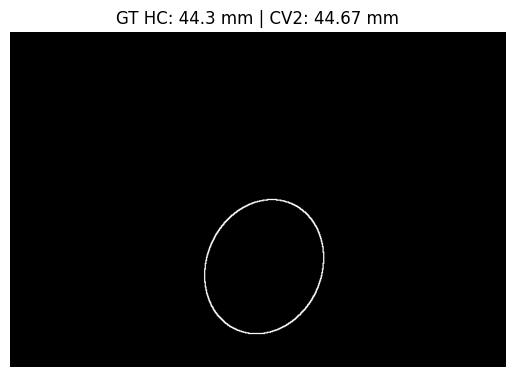

In [17]:
import matplotlib.pyplot as plt

row = df.iloc[0]
ann_path = os.path.join(
    TRAIN_DIR,
    row["filename"].replace(".png", "_Annotation.png")
)

ann = cv2.imread(ann_path, 0)
pixel_size = row["pixel size(mm)"]

hc_pred = calculate_ellipse_perimeter(ann_path, pixel_size)

plt.imshow(ann, cmap="gray")
plt.title(f"GT HC: {row['head circumference (mm)']} mm | CV2: {hc_pred:.2f} mm")
plt.axis("off")
plt.savefig('hc_val.png')
plt.show()
